In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_power = pd.read_csv('CleanTechData/Plant_1_Generation_Data.csv')
df_weather = pd.read_csv('CleanTechData/Plant_1_Weather_Sensor_Data.csv')

# Convert DATE_TIME columns to datetime
df_power['DATE_TIME'] = pd.to_datetime(df_power['DATE_TIME'], format="%d-%m-%Y %H:%M")
df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'], format="%Y-%m-%d %H:%M")

# Merge on DATE_TIME and PLANT_ID
df_solar = pd.merge(df_power, df_weather, on=['DATE_TIME'], how='inner')
df_solar.drop(['PLANT_ID_x',	'PLANT_ID_y', 'SOURCE_KEY_x', 'SOURCE_KEY_y', 'DAILY_YIELD',	'TOTAL_YIELD'], axis = 1, inplace = True)

df_solar.head()

,DATE_TIME,DC_POWER,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,0.0,0.0,25.184316,22.857507,0.0
1,2020-05-15,0.0,0.0,25.184316,22.857507,0.0
2,2020-05-15,0.0,0.0,25.184316,22.857507,0.0
3,2020-05-15,0.0,0.0,25.184316,22.857507,0.0
4,2020-05-15,0.0,0.0,25.184316,22.857507,0.0


In [4]:
# Extract time (hour, minute, second) only
#df_solar['DATE_TIME'] = pd.to_datetime(df_solar['DATE_TIME'])
#df_solar['TIME_OF_DAY'] = df_solar['DATE_TIME'].dt.time
#df_solar.drop(['AC_POWER', 'MODULE_TEMPERATURE', 'DATE_TIME'], axis = 1, inplace= True)

for col in df_solar.columns:
    print(f"--- Value counts for column: {col} ---")
    print(df_solar[col].value_counts(dropna=False))  # dropna=False includes NaN
    print("\n")

--- Value counts for column: DC_POWER ---
0.000000       31951
66.000000          7
26.000000          5
376.000000         5
1842.000000        5
               ...  
1849.428571        1
1889.750000        1
1888.375000        1
1917.875000        1
74.857143          1
Name: DC_POWER, Length: 32906, dtype: int64


--- Value counts for column: AMBIENT_TEMPERATURE ---
29.979580    22
22.055740    22
22.224561    22
22.306429    22
22.263181    22
             ..
24.031464    10
25.192544    10
24.911574    10
27.052079    10
23.065572     4
Name: AMBIENT_TEMPERATURE, Length: 3157, dtype: int64


--- Value counts for column: IRRADIATION ---
0.000000    30398
0.086953       22
0.107214       22
0.056334       22
0.028989       22
            ...  
0.002115       10
0.008883       10
0.014272       10
0.000028       10
0.000065       10
Name: IRRADIATION, Length: 1755, dtype: int64


--- Value counts for column: TIME_OF_DAY ---
09:45:00    748
08:30:00    748
11:00:00    748
21:30:00    

In [ ]:
for col in df.columns:
    print(f"--- Value counts for column: {col} ---")
    print(df[col].value_counts(dropna=False))  # dropna=False includes NaN
    print("\n")
    

,DC_POWER,AMBIENT_TEMPERATURE,IRRADIATION
DC_POWER,1.000000,0.724668,0.989391
AMBIENT_TEMPERATURE,0.724668,1.000000,0.725278
IRRADIATION,0.989391,0.725278,1.000000


In [6]:


df_solar.describe().style.background_gradient(cmap='rainbow')



,DC_POWER,AMBIENT_TEMPERATURE,IRRADIATION
count,68774.000000,68774.000000,68774.000000
mean,3147.177450,25.558521,0.232305
std,4036.441826,3.361300,0.301948
min,0.000000,20.398505,0.000000
25%,0.000000,22.724491,0.000000
50%,428.571429,24.670178,0.031620
75%,6365.468750,27.960429,0.454880
max,14471.125000,35.252486,1.221652


#### Data is taken from from https://www.kaggle.com/datasets/lambda21525702290303/solar-energy-prediction

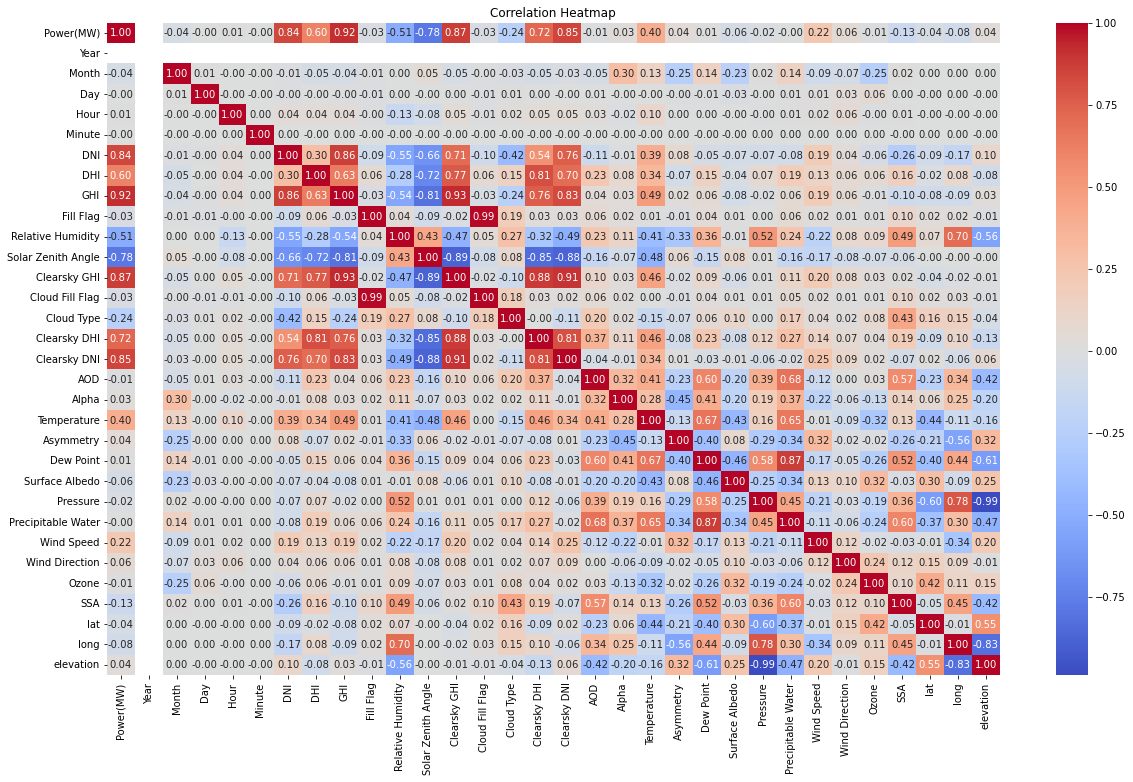

In [ ]:
df_power = pd.read_csv('CleanTechData/usaWithWeather.csv')

# Compute correlation matrix
corr = df_power.corr()

# Plot heatmap
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



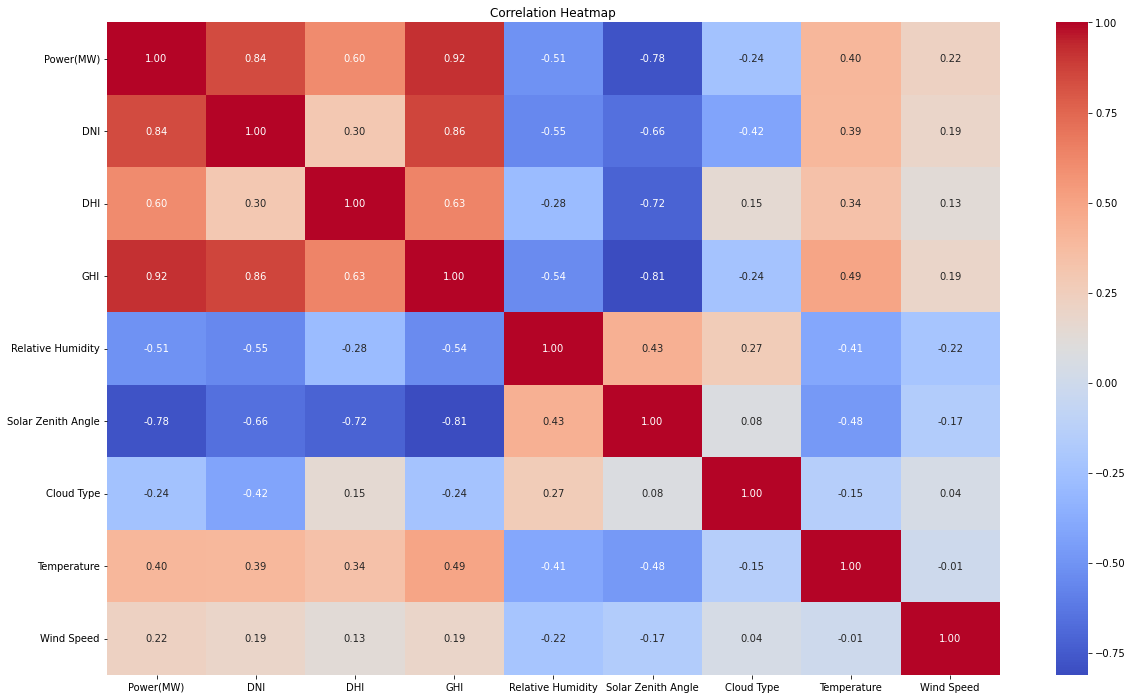

In [14]:
df_power_filtered = df_power[['LocalTime',	'Power(MW)', 'DNI',	'DHI',	'GHI', 'Relative Humidity', 'Solar Zenith Angle', 'Cloud Type', 'Temperature', 'Wind Speed']]

# Compute correlation matrix
corr = df_power_filtered.corr()

# Plot heatmap
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()
